# 1. Import Dependencies

In [1]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [2]:
import os
import config
os.makedirs(config.DATA_DIR,exist_ok=True)

In [3]:
import pandas as pd
import random
from tqdm import tqdm
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import random
from torch.utils.data import DataLoader,random_split

C:\Users\Skyfire\anaconda3\envs\py39-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Download Data and Generate dataloader

In [4]:
# load the training and test datasets
train_data = datasets.MNIST(root=config.DATA_DIR, train=True,
                                   download=True)
test_data = datasets.MNIST(root=config.DATA_DIR, train=False,
                                  download=True)

In [5]:
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=config.BATCH_SIZE, num_workers=config.NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=config.BATCH_SIZE, num_workers=config.NUM_WORKERS)

## Visualize the dataset

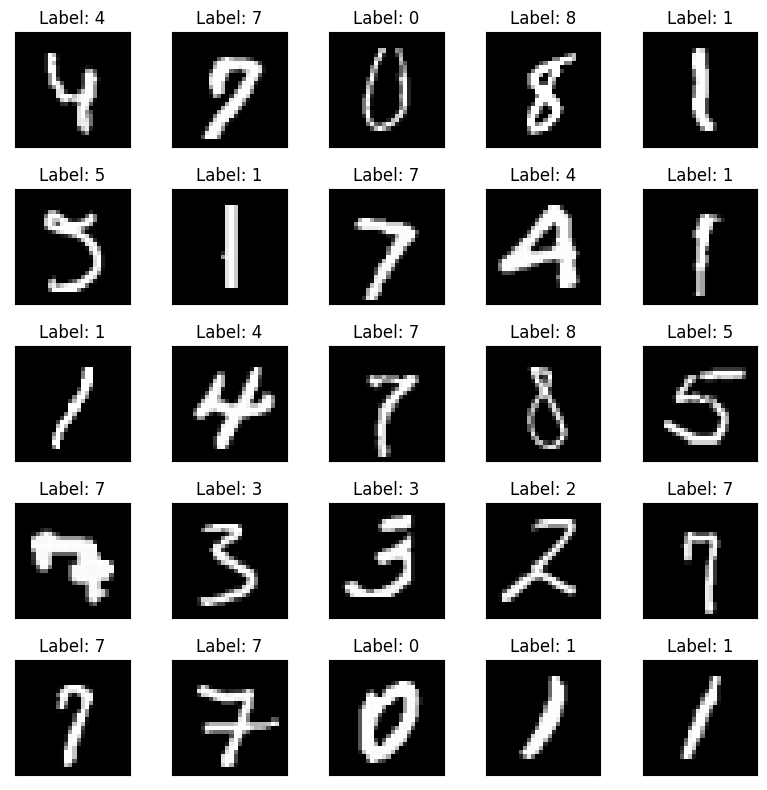

In [6]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_data)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Transform Dataloader

In [7]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_data.transform = train_transform
# Set the test transform
test_data.transform = test_transform

In [8]:
m=len(train_data)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_data, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

# 3. Initialize model

In [9]:
from engine import Engine

In [10]:
torch.manual_seed(0)
engine = Engine(encoded_space_dim=4,num_epochs=config.NUM_EPOCHS)

In [11]:
encoder, decoder = engine.get_autoencoder()

## Some Examples

In [12]:
# Take an input image (remember to add the batch dimension)
img, _ = test_data[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image

img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)

# Decode the image
dec_img = decoder(img_enc)
#dec_img = model(img)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 4])
Decoded image shape: torch.Size([1, 1, 28, 28])


# 4. Train Model

In [13]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001
#lr = 0.0008 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

In [14]:
loss_data = engine.train_model(train_loader,valid_loader, loss_fn, optim)


 EPOCH 1/30 	 train loss0.123 	 val loss 0.064

 EPOCH 6/30 	 train loss0.031 	 val loss 0.030

 EPOCH 11/30 	 train loss0.028 	 val loss 0.028

 EPOCH 16/30 	 train loss0.027 	 val loss 0.027

 EPOCH 21/30 	 train loss0.026 	 val loss 0.027

 EPOCH 26/30 	 train loss0.026 	 val loss 0.026


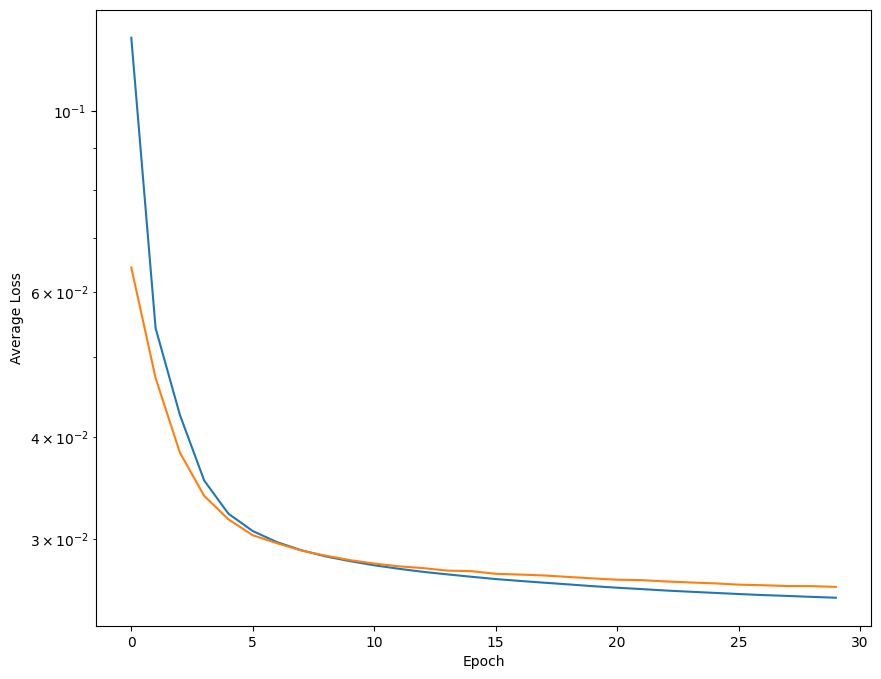

In [15]:
engine.plot_train_loss(loss_data)

# 5. Latent Space Exploration

In [16]:
import embedding_util as util

In [17]:
# Generate embeddings dataframe
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoder = torch.load('temp\\best_encoder.pth')
embeddings_df = util.get_latent_space_embeddings(test_data, device, encoder)

100%|██████████| 10000/10000 [00:10<00:00, 963.27it/s]


In [19]:
embeddings_df

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,-2.156957,1.356293,0.868669,-0.030253,7
1,0.622532,0.527489,0.878197,0.512245,2
2,-0.398128,1.152459,-0.153160,1.318313,1
3,0.285594,-0.832727,0.101697,-0.426663,0
4,-0.542652,0.108630,-0.778222,-0.560744,4
...,...,...,...,...,...
9995,-0.134558,0.397608,1.121550,0.412482,2
9996,0.792502,0.123362,0.798242,-0.012491,3
9997,-1.054464,0.172812,-0.975393,0.201375,4
9998,-0.264681,-0.454556,0.019442,0.462876,5


In [20]:
embeddings_df.label

0       7
1       2
2       1
3       0
4       4
       ..
9995    2
9996    3
9997    4
9998    5
9999    6
Name: label, Length: 10000, dtype: int64

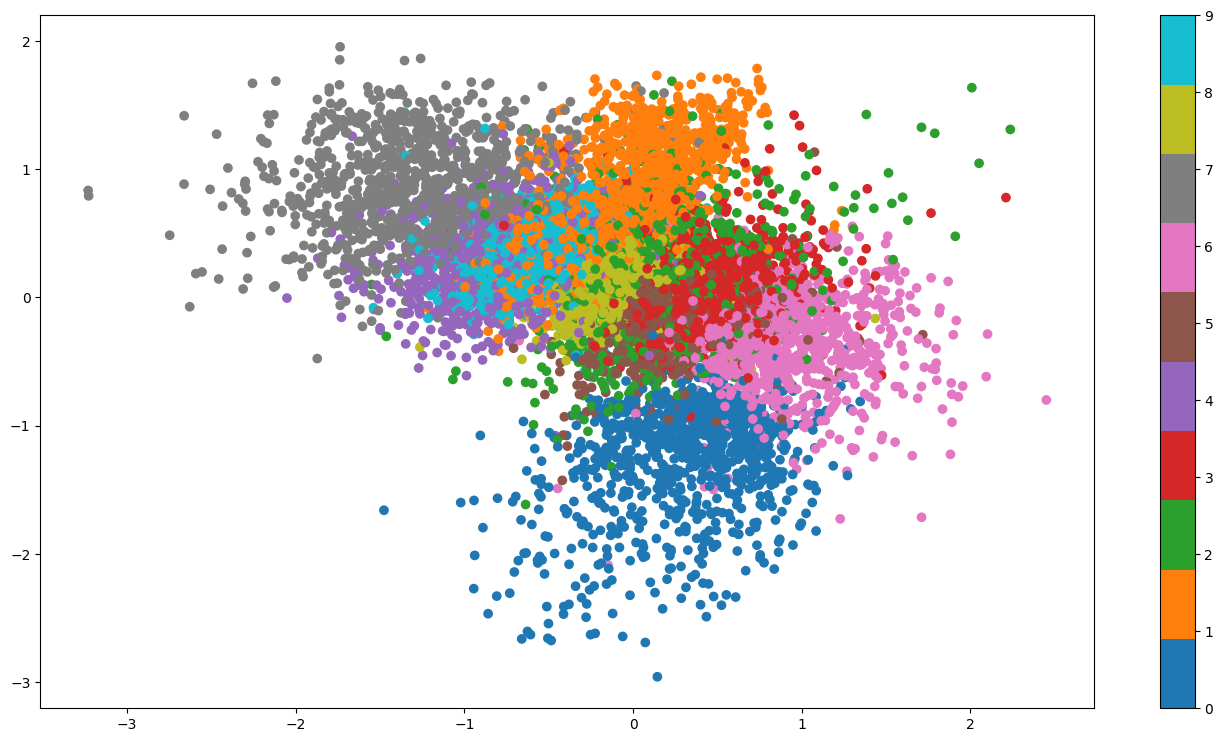

In [22]:
util.visualize_embeddings_2D(embeddings_df['Enc. Variable 0'], embeddings_df['Enc. Variable 1'], embeddings_df.label)

## Cluster Latent Space and visualize

In [24]:
from sklearn.manifold import TSNE

C:\Users\Skyfire\anaconda3\envs\py39-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Skyfire\anaconda3\envs\py39-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


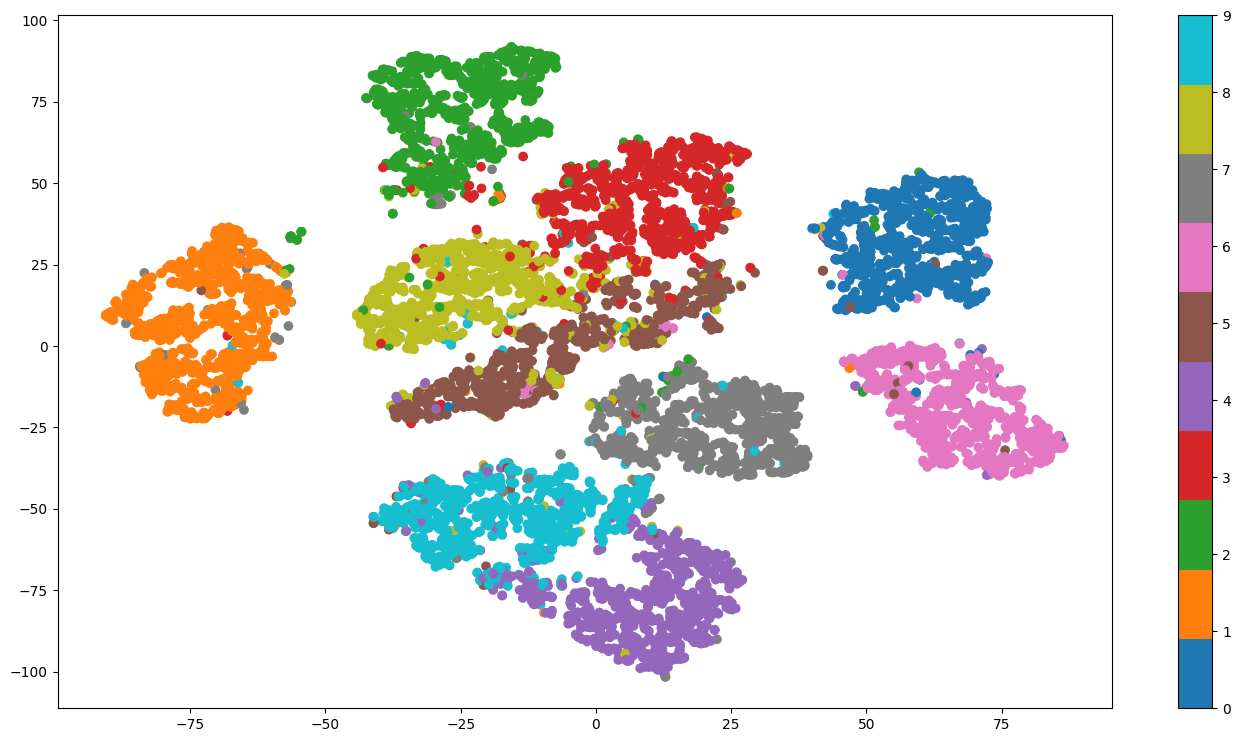

In [25]:
tsne = TSNE(n_components=2)
util.cluster_latent_space(tsne, embeddings_df)